In [152]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


In [153]:
data_set_conaminantes = pd.read_csv('../../data/processed/normalizados/Dataset_MinMax.csv',sep=';', thousands=None, decimal=',')
data_set_conaminantes['fecha'] = pd.to_datetime(data_set_conaminantes['fecha'])

In [154]:
# Crear columnas para cada estación y llenar con 0
data_set_conaminantes['es_Primavera'] = 0
data_set_conaminantes['es_Verano'] = 0
data_set_conaminantes['es_Otoño'] = 0
data_set_conaminantes['es_Invierno'] = 0

def get_estacion(fecha):
    dia = fecha.timetuple().tm_yday
    
    # Definiendo los días del año para los cambios de estación en el hemisferio sur
    verano = 355  # ~21 de diciembre
    otoño = 80     # ~21 de marzo
    invierno = 172  # ~21 de junio
    primavera = 264  # ~21 de septiembre
    
    # Determinar la estación basada en el día del año
    if verano <= dia or dia < otoño:
        return 'Verano'
    elif otoño <= dia < invierno:
        return 'Otoño'
    elif invierno <= dia < primavera:
        return 'Invierno'
    else:
        return 'Primavera'



# Actualizar las columnas de estación basado en la fecha
for index, row in data_set_conaminantes.iterrows():
    estacion = get_estacion(row['fecha'])
    
    if estacion == 'Primavera':
        data_set_conaminantes.at[index, 'es_Primavera'] = 1
    elif estacion == 'Verano':
        data_set_conaminantes.at[index, 'es_Verano'] = 1
    elif estacion == 'Otoño':
        data_set_conaminantes.at[index, 'es_Otoño'] = 1
    elif estacion == 'Invierno':
        data_set_conaminantes.at[index, 'es_Invierno'] = 1

In [155]:
data_set_conaminantes = data_set_conaminantes.drop(['fecha'],axis=1)
data_set_conaminantes = data_set_conaminantes.drop(['dd_Valor'],axis=1)


X = data_set_conaminantes[['humedad', 
                           'puntoRocio', 
                           'temperatura', 
                           'ff_Valor', 
                           'es_Primavera', 
                           'es_Verano', 
                           'es_Otoño', 
                           'es_Invierno']]

y = data_set_conaminantes[['pm10', 'pm2.5']]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# El 20% restante se utilizará para pruebas y test finales.
# X_val, X_test, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [156]:
# Aplicar PCA con 6 componentes principales
pca = PCA(n_components=6)


X_train_pca = pca.fit_transform(X_train)

X_temp_pca = pca.transform(X_temp)

# Ver la varianza explicada por los componentes
print(f'Varianza explicada por los componentes: {pca.explained_variance_ratio_}')


Varianza explicada por los componentes: [0.35813107 0.28548806 0.28043003 0.03563317 0.02294222 0.01712502]


In [157]:
# Crear modelo de red neuronal
model = Sequential([
    Dense(6, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(1, activation='linear')  
])

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# entrenar modelo usandod pm10 como objetivo
model.fit(X_train_pca, y_train, epochs=50, validation_split=0.2, batch_size=42, verbose=0)


In [158]:
y_pred = model.predict(X_temp_pca)


24/24 [==============================] - 0s 739us/step


In [159]:
# Calcular métricas
mae = mean_absolute_error(y_temp[['pm10']], y_pred)
mse = mean_squared_error(y_temp[['pm10']], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_temp[['pm2.5']], y_pred)

# Mostrar métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.025827557309634378
MSE: 0.002197389243864452
RMSE: 0.04687631858267512
R^2: 0.18834758272509988


C:\Users\benja\AppData\Local\Temp\ipykernel_2728\181494154.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()],


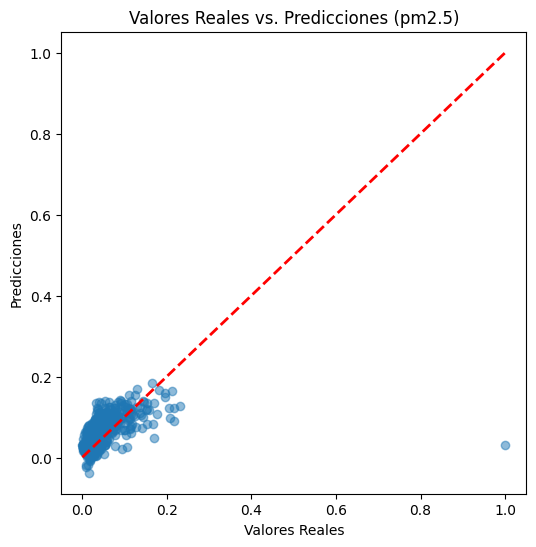

In [160]:
plt.figure(figsize=(6, 6))
plt.scatter(y_temp[['pm2.5']], y_pred[:, 0], alpha=0.5)
plt.title('Valores Reales vs. Predicciones (pm2.5)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()], 
         [y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()],
         '--k', linewidth=2, color='red')
plt.show()


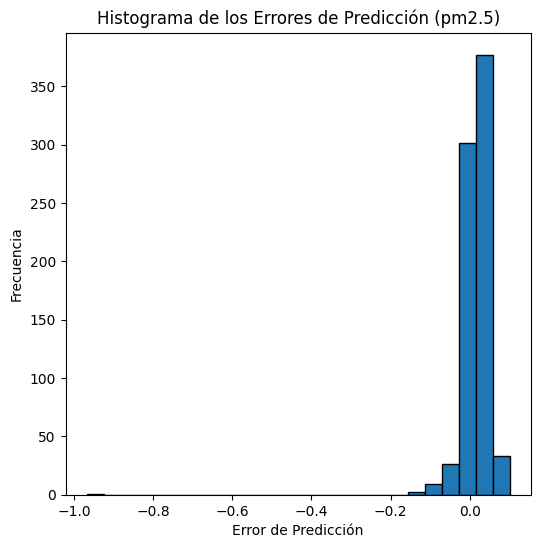

In [161]:
plt.figure(figsize=(6, 6))
error_pm25 = y_pred[:, 0].flatten() - y_temp[['pm2.5']].values.flatten()
plt.hist(error_pm25, bins=25, edgecolor='black')
plt.title('Histograma de los Errores de Predicción (pm2.5)')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()


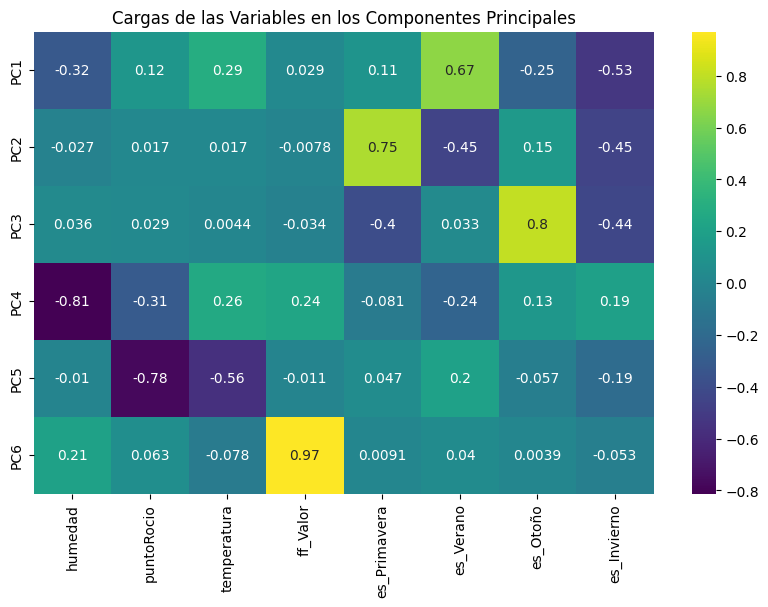

In [163]:
# Crear un DataFrame con los componentes
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])

# visualizar las cargas de las variables originales en los componentes principales
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap='viridis', annot=True)
plt.title('Cargas de las Variables en los Componentes Principales')
plt.show()